# Recriar Estudo 2

In [1]:
import sys
print(sys.executable)

/home/magda/tf-gpu-env/bin/python3.10


**Ver se está a usar a GPU**

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2025-07-03 21:12:53.579035: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-03 21:12:54.836460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7371822821227671598
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2351693824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1269137981550445776
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2025-07-03 21:12:56.827954: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-03 21:12:56.963612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-03 21:12:56.963665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-03 21:12:57.142916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-03 21:12:57.142993: I tensorflow/compile

**imports**

In [3]:
import os
# Ativa o alocador assíncrono (melhora fragmentação de memória)
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf
# Ativa a alocação dinâmica de memória (não ocupa toda a memória no início)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Erro ao definir memory growth:", e)
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, GlobalAveragePooling2D, Dense, ReLU, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_auc_score

print("TensorFlow:", tf.__version__)
print("TensorFlow Addons:", tfa.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", matplotlib.__version__)

2025-07-03 21:12:57.154917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-03 21:12:57.155034: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-03 21:12:57.155073: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
/home/magda/tf-gpu-env/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.


TensorFlow: 2.13.0
TensorFlow Addons: 0.21.0
NumPy: 1.23.5
Pandas: 1.5.3
Matplotlib: 3.7.1


## Arquitetura do Modelo:

In [4]:
# Entrada
input_layer = Input(shape=(224, 224, 3))

# Primeira camada
x = Conv2D(48, (3,3), strides=2, padding='same')(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(24, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(72, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(24, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_1
for _ in range(2):
    x = Conv2D(72, (1,1), strides=1, padding='same')(x)  # 24 -> 72
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(24, (1,1), strides=1, padding='same')(x)  # 72 -> 24
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
# Expandir de novo
x = Conv2D(72, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=5, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(56, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_2
for _ in range(2):
    x = Conv2D(168, (1,1), strides=1, padding='same')(x)  # 56 -> 168
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = DepthwiseConv2D(kernel_size=5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(56, (1,1), strides=1, padding='same')(x)  # 168 -> 56
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Expandir de novo
x = Conv2D(336, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=5, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(104, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_3
for _ in range(2):
    x = Conv2D(624, (1,1), strides=1, padding='same')(x)  # 104 -> 624
    x = BatchNormalization()(x)
    x = ReLU()(x)    
    x = DepthwiseConv2D(kernel_size=5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)    
    x = Conv2D(104, (1,1), strides=1, padding='same')(x)  # 624 -> 104
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Expandir
x = Conv2D(624, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(136, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_4
x = Conv2D(816, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(136, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# Entre conv_blocks
x = Conv2D(816, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=5, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(272, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_5
for _ in range(3):
    x = Conv2D(1632, (1,1), strides=1, padding='same')(x)  # 272 -> 1632
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = DepthwiseConv2D(kernel_size=5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(272, (1,1), strides=1, padding='same')(x)  # 1632 -> 272
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Finalização
x = Conv2D(1632, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(448, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(1280, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# Pooling global e classificação
x = GlobalAveragePooling2D()(x)
output_layer = Dense(2, activation='softmax')(x)

# Modelo
model = Model(inputs=input_layer, outputs=output_layer)

2025-06-24 21:52:27.458615: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 21:52:27.458717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 21:52:27.458753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 21:52:27.459004: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 21:52:27.459020: I tensorflow/core/co

In [5]:
# Compilar o modelo
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=2, average='macro')
    ]
)

In [6]:
# Mostrar resumo
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 48)      1344      
                                                                 
 batch_normalization (Batch  (None, 112, 112, 48)      192       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 112, 112, 48)      0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 112, 112, 48)      480       
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 48)      192   

## Funções Auxiliares

Trata do pré-processamento das imagens, ou seja redimensiona para 224 X 224 pixels e normaliza [0,1] e coloca em one hot.

In [4]:
# Função auxiliar para carregar imagem
def preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    label = tf.one_hot(label, 2)
    return image, label

Permite analisar a distribuição dos datasets.

In [5]:
def inspect_dataset_distribution(dataset, name="dataset"):
    total_samples = 0
    label_counter = Counter()

    for images, labels in dataset:
        # labels vêm em one-hot: [0,1] ou [1,0]
        labels_np = labels.numpy()
        class_indices = labels_np.argmax(axis=1)  # <-- Corrigir: pegar o índice da classe correta
        total_samples += len(class_indices)
        label_counter.update(class_indices)

    print(f"📊 {name.upper()} -> Total de imagens: {total_samples}")
    for label, count in sorted(label_counter.items()):
        perc = (count / total_samples) * 100
        print(f"  Classe {int(label)} ({'Fogo' if label == 1 else 'Sem fogo'}): {count} imagens ({perc:.2f}%)")
    print("-" * 40)

Permite analisar o histórico de trino.

In [9]:
def plot_training_history(history):
    metrics = history.history.keys()
    epochs_range = range(len(history.history['loss']))

    for metric in metrics:
        if "val_" not in metric:
            plt.figure(figsize=(10, 5))
            plt.plot(epochs_range, history.history[metric], label=f"Train {metric}")
            if f"val_{metric}" in metrics:
                plt.plot(epochs_range, history.history[f"val_{metric}"], label=f"Val {metric}")
            plt.title(f"Training and Validation {metric.capitalize()}")
            plt.xlabel("Epochs")
            plt.ylabel(metric.capitalize())
            plt.legend()
            plt.grid(True)
            plt.show()

Usada para avaliar o modelo, ou seja, se está a prever corretamente a classificação das imagens.

In [6]:
def avaliar_modelo(model, dataset):
    # 1. Previsões e rótulos reais
    y_pred_probs = model.predict(dataset, verbose=0)
    y_true = np.concatenate([y for _, y in dataset], axis=0)
    y_true_int = np.argmax(y_true, axis=1)
    y_pred_int = (y_pred_probs[:, 1] > 0.5).astype(int)

    # 2. Contagem das classes
    TP = np.sum((y_true_int == 1) & (y_pred_int == 1))
    TN = np.sum((y_true_int == 0) & (y_pred_int == 0))
    FP = np.sum((y_true_int == 0) & (y_pred_int == 1))
    FN = np.sum((y_true_int == 1) & (y_pred_int == 0))

    total = TP + TN + FP + FN

    # 3. Cálculo das métricas com base nas fórmulas
    accuracy   = (TP + TN) / total if total > 0 else 0.0
    precision  = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall     = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_score   = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    auc        = roc_auc_score(y_true_int, y_pred_probs[:, 1])

    # Categorical crossentropy loss
    eps = 1e-7
    p = np.clip(y_pred_probs, eps, 1 - eps)
    y = y_true
    loss = -np.mean(np.sum(y * np.log(p), axis=1))

    # Métricas específicas de detecção de incêndio
    fdr = recall * 100  # ou (TP / (TP + FN)) * 100
    ewr = ((FP + FN) / total) * 100 if total > 0 else 0.0

    # 4. Impressão
    print("=== MÉTRICAS DE AVALIAÇÃO ===")
    print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")
    print(f"Accuracy       : {accuracy:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"F1-Score       : {f1_score:.4f}")
    print(f"AUC            : {auc:.4f}")
    print(f"Loss    : {loss:.4f}")
    print(f"FDR (Fire Detection Rate)      : {fdr:.2f} %")
    print(f"EWR (Error Warning Rate)       : {ewr:.2f} %")
    print("Confusion Matrix:")
    print(np.array([[TN, FP], [FN, TP]]))  # [[negativos reais], [positivos reais]]

    # 5. Retorno opcional
    return {
        'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'auc': auc,
        'loss': loss,
        'fdr': fdr,
        'ewr': ewr,
        'confusion_matrix': np.array([[TN, FP], [FN, TP]])
    }

## Treino

In [7]:
# Configurações gerais
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16
EPOCHS = 50
SEED = 42

In [8]:
data = pd.read_csv("../Datasets/Estudo2_Recriado.csv")
image_paths = data['image_path'].values
labels = data['label_bi'].values

In [9]:
# Dividir em treino, validação e teste (80/10/10)
x_train, x_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.2, random_state=SEED, stratify=labels)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)

In [10]:
# Criar datasets TensorFlow
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess_image).shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

2025-07-03 21:13:53.245990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-03 21:13:53.246160: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-03 21:13:53.246238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-03 21:13:53.246645: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-03 21:13:53.246660: I tensorflow/core/co

In [11]:
inspect_dataset_distribution(train_ds, name="train")
inspect_dataset_distribution(val_ds, name="val")
inspect_dataset_distribution(test_ds, name="test")

📊 TRAIN -> Total de imagens: 4492
  Classe 0 (Sem fogo): 2209 imagens (49.18%)
  Classe 1 (Fogo): 2283 imagens (50.82%)
----------------------------------------
📊 VAL -> Total de imagens: 562
  Classe 0 (Sem fogo): 276 imagens (49.11%)
  Classe 1 (Fogo): 286 imagens (50.89%)
----------------------------------------
📊 TEST -> Total de imagens: 561
  Classe 0 (Sem fogo): 276 imagens (49.20%)
  Classe 1 (Fogo): 285 imagens (50.80%)
----------------------------------------


In [16]:
callback = [
    ModelCheckpoint('Recriar_Estudo_2_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

In [17]:
# Treinar
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callback
)

Epoch 1/50


2025-06-24 21:52:39.823740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-06-24 21:52:41.403973: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7af6740a8f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-24 21:52:41.404019: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-06-24 21:52:41.449387: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-24 21:52:41.703517: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-06-24 21:52:41.872085: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.25GiB with freed_by_count=0. The c

280/281 [============================>.] - ETA: 0s - loss: 0.4630 - accuracy: 0.7984 - precision: 0.7984 - recall: 0.7984 - auc: 0.8786 - f1_score: 0.7968

2025-06-24 21:53:38.034137: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-24 21:53:38.034209: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


281/281 [==============================] - ETA: 0s - loss: 0.4625 - accuracy: 0.7985 - precision: 0.7985 - recall: 0.7985 - auc: 0.8788 - f1_score: 0.7968
Epoch 1: val_loss improved from inf to 0.70397, saving model to Recriar_Estudo_2_best.h5


/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


281/281 [==============================] - 73s 159ms/step - loss: 0.4625 - accuracy: 0.7985 - precision: 0.7985 - recall: 0.7985 - auc: 0.8788 - f1_score: 0.7968 - val_loss: 0.7040 - val_accuracy: 0.5089 - val_precision: 0.5089 - val_recall: 0.5089 - val_auc: 0.5089 - val_f1_score: 0.3373
Epoch 2/50
281/281 [==============================] - ETA: 0s - loss: 0.3332 - accuracy: 0.8615 - precision: 0.8615 - recall: 0.8615 - auc: 0.9330 - f1_score: 0.8612
Epoch 2: val_loss did not improve from 0.70397
281/281 [==============================] - 40s 142ms/step - loss: 0.3332 - accuracy: 0.8615 - precision: 0.8615 - recall: 0.8615 - auc: 0.9330 - f1_score: 0.8612 - val_loss: 0.7624 - val_accuracy: 0.4911 - val_precision: 0.4911 - val_recall: 0.4911 - val_auc: 0.5069 - val_f1_score: 0.3294
Epoch 3/50
281/281 [==============================] - ETA: 0s - loss: 0.3061 - accuracy: 0.8782 - precision: 0.8782 - recall: 0.8782 - auc: 0.9433 - f1_score: 0.8780
Epoch 3: val_loss improved from 0.70397 t

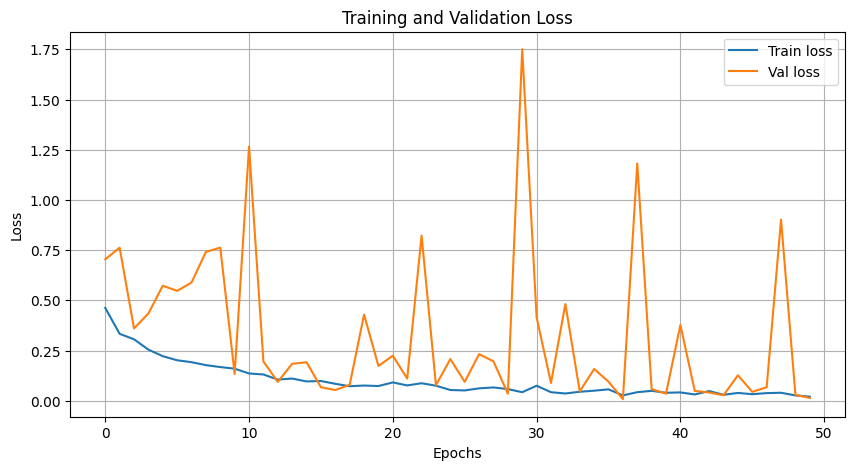

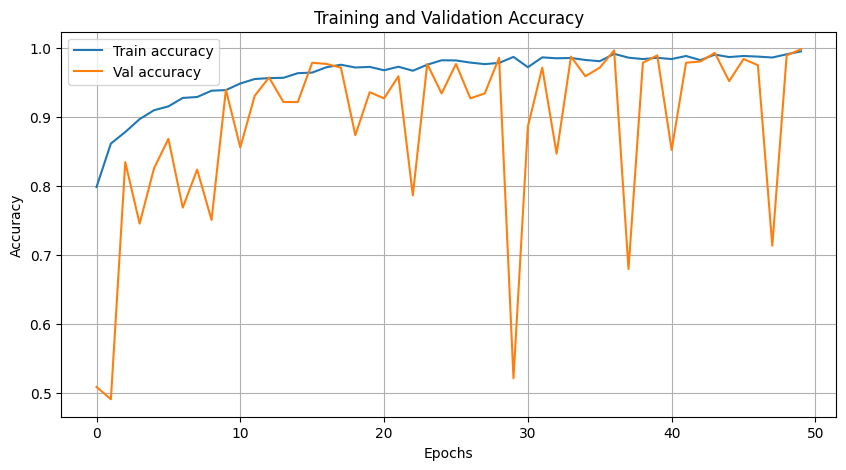

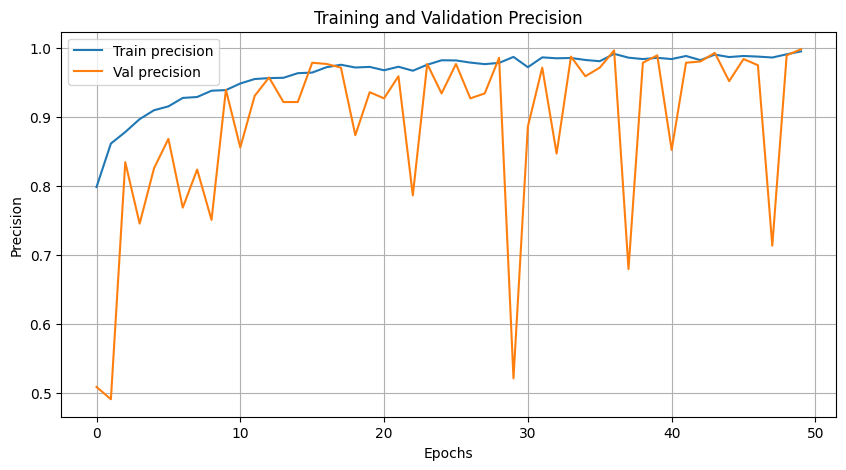

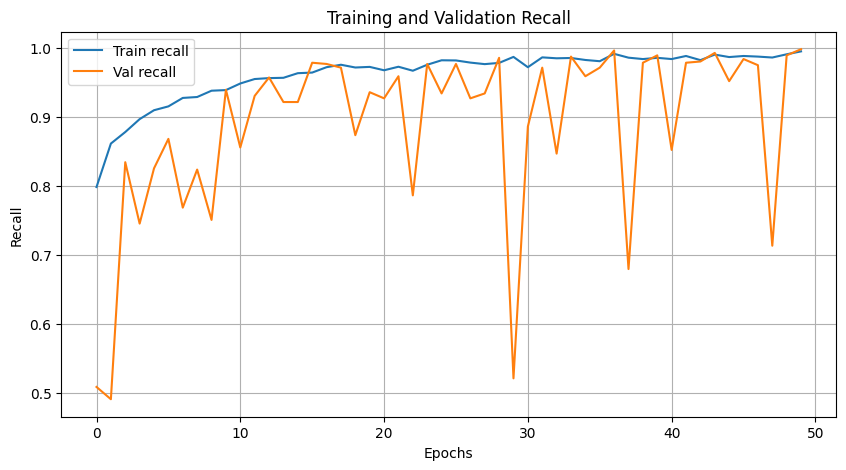

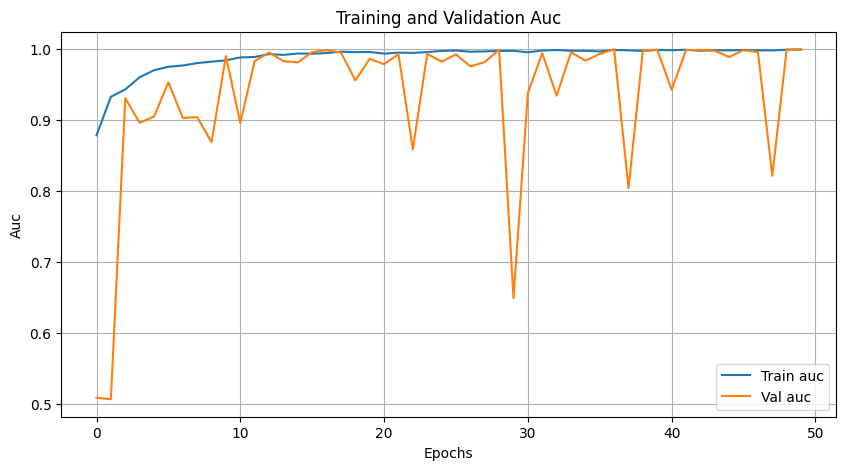

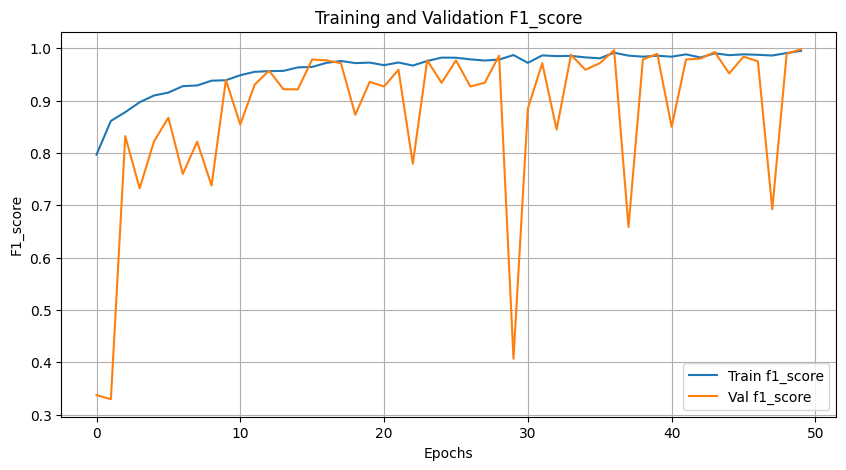

In [18]:
plot_training_history(history)

In [19]:
# Converter o histórico em DataFrame
history = pd.DataFrame(history.history)
# Salvar em CSV
history.to_csv('Recriar_Estudo_2_train_history.csv', index=False)

In [20]:
model.save('Recriar_Estudo_2.h5')

/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Avaliar

In [12]:
model = load_model('Recriar_Estudo_2.h5')

In [13]:
avaliar_modelo(model, test_ds)

2025-07-03 21:14:14.616709: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


=== MÉTRICAS DE AVALIAÇÃO ===
TP=284, TN=271, FP=5, FN=1
Accuracy       : 0.9893
Precision      : 0.9827
Recall         : 0.9965
F1-Score       : 0.9895
AUC            : 0.9986
Loss    : 0.0427
FDR (Fire Detection Rate)      : 99.65 %
EWR (Error Warning Rate)       : 1.07 %
Confusion Matrix:
[[271   5]
 [  1 284]]


{'TP': 284,
 'TN': 271,
 'FP': 5,
 'FN': 1,
 'accuracy': 0.9893048128342246,
 'precision': 0.9826989619377162,
 'recall': 0.9964912280701754,
 'f1_score': 0.9895470383275261,
 'auc': 0.99860157640478,
 'loss': 0.04265205,
 'fdr': 99.64912280701755,
 'ewr': 1.06951871657754,
 'confusion_matrix': array([[271,   5],
        [  1, 284]])}

In [14]:
model_best = load_model('Recriar_Estudo_2_best.h5')

In [15]:
avaliar_modelo(model_best, test_ds)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=284, TN=271, FP=5, FN=1
Accuracy       : 0.9893
Precision      : 0.9827
Recall         : 0.9965
F1-Score       : 0.9895
AUC            : 0.9988
Loss    : 0.0456
FDR (Fire Detection Rate)      : 99.65 %
EWR (Error Warning Rate)       : 1.07 %
Confusion Matrix:
[[271   5]
 [  1 284]]


{'TP': 284,
 'TN': 271,
 'FP': 5,
 'FN': 1,
 'accuracy': 0.9893048128342246,
 'precision': 0.9826989619377162,
 'recall': 0.9964912280701754,
 'f1_score': 0.9895470383275261,
 'auc': 0.9988176964149504,
 'loss': 0.045571357,
 'fdr': 99.64912280701755,
 'ewr': 1.06951871657754,
 'confusion_matrix': array([[271,   5],
        [  1, 284]])}

## Testar no FLAME train

In [16]:
data = pd.read_csv("../Datasets/FLAME_train.csv")
image_paths_flame_train = data['image_path'].values
labels_flame_train = data['label_bi'].values

test_ds_flame_train = tf.data.Dataset.from_tensor_slices((image_paths_flame_train, labels_flame_train))
test_ds_flame_train = test_ds_flame_train.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_train, name="FLAME train")

📊 FLAME TRAIN -> Total de imagens: 39375
  Classe 0 (Sem fogo): 14357 imagens (36.46%)
  Classe 1 (Fogo): 25018 imagens (63.54%)
----------------------------------------


In [17]:
avaliar_modelo(model, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=24895, TN=14317, FP=40, FN=123
Accuracy       : 0.9959
Precision      : 0.9984
Recall         : 0.9951
F1-Score       : 0.9967
AUC            : 0.9998
Loss    : 0.0156
FDR (Fire Detection Rate)      : 99.51 %
EWR (Error Warning Rate)       : 0.41 %
Confusion Matrix:
[[14317    40]
 [  123 24895]]


{'TP': 24895,
 'TN': 14317,
 'FP': 40,
 'FN': 123,
 'accuracy': 0.9958603174603174,
 'precision': 0.998395829155805,
 'recall': 0.995083539851307,
 'f1_score': 0.9967369327167536,
 'auc': 0.9998085031351085,
 'loss': 0.015630499,
 'fdr': 99.50835398513071,
 'ewr': 0.41396825396825393,
 'confusion_matrix': array([[14317,    40],
        [  123, 24895]])}

In [18]:
avaliar_modelo(model_best, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=24891, TN=14285, FP=72, FN=127
Accuracy       : 0.9949
Precision      : 0.9971
Recall         : 0.9949
F1-Score       : 0.9960
AUC            : 0.9998
Loss    : 0.0170
FDR (Fire Detection Rate)      : 99.49 %
EWR (Error Warning Rate)       : 0.51 %
Confusion Matrix:
[[14285    72]
 [  127 24891]]


{'TP': 24891,
 'TN': 14285,
 'FP': 72,
 'FN': 127,
 'accuracy': 0.9949460317460318,
 'precision': 0.9971157312822978,
 'recall': 0.9949236549684227,
 'f1_score': 0.9960184870250696,
 'auc': 0.9997980906279345,
 'loss': 0.016968071,
 'fdr': 99.49236549684227,
 'ewr': 0.5053968253968254,
 'confusion_matrix': array([[14285,    72],
        [  127, 24891]])}

## Testar no FLAME test

In [19]:
data = pd.read_csv("../Datasets/FLAME_test.csv")
image_paths_flame_test = data['image_path'].values
labels_flame_test = data['label_bi'].values

test_ds_flame_test = tf.data.Dataset.from_tensor_slices((image_paths_flame_test, labels_flame_test))
test_ds_flame_test = test_ds_flame_test.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_test, name="FLAME test")

📊 FLAME TEST -> Total de imagens: 8617
  Classe 0 (Sem fogo): 3480 imagens (40.39%)
  Classe 1 (Fogo): 5137 imagens (59.61%)
----------------------------------------


In [20]:
avaliar_modelo(model, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=5081, TN=3378, FP=102, FN=56
Accuracy       : 0.9817
Precision      : 0.9803
Recall         : 0.9891
F1-Score       : 0.9847
AUC            : 0.9983
Loss    : 0.0536
FDR (Fire Detection Rate)      : 98.91 %
EWR (Error Warning Rate)       : 1.83 %
Confusion Matrix:
[[3378  102]
 [  56 5081]]


{'TP': 5081,
 'TN': 3378,
 'FP': 102,
 'FN': 56,
 'accuracy': 0.9816641522571661,
 'precision': 0.9803202778313718,
 'recall': 0.9890986957368114,
 'f1_score': 0.9846899224806202,
 'auc': 0.998267331440373,
 'loss': 0.053612188,
 'fdr': 98.90986957368114,
 'ewr': 1.8335847742833933,
 'confusion_matrix': array([[3378,  102],
        [  56, 5081]])}

In [21]:
avaliar_modelo(model_best, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=5016, TN=3315, FP=165, FN=121
Accuracy       : 0.9668
Precision      : 0.9682
Recall         : 0.9764
F1-Score       : 0.9723
AUC            : 0.9930
Loss    : 0.1032
FDR (Fire Detection Rate)      : 97.64 %
EWR (Error Warning Rate)       : 3.32 %
Confusion Matrix:
[[3315  165]
 [ 121 5016]]


{'TP': 5016,
 'TN': 3315,
 'FP': 165,
 'FN': 121,
 'accuracy': 0.9668097945920854,
 'precision': 0.9681528662420382,
 'recall': 0.9764453961456103,
 'f1_score': 0.9722814498933902,
 'auc': 0.9929859773247501,
 'loss': 0.103198186,
 'fdr': 97.64453961456103,
 'ewr': 3.3190205407914584,
 'confusion_matrix': array([[3315,  165],
        [ 121, 5016]])}

## Testar no UAVS Raw Images

In [22]:
data = pd.read_csv("../Datasets/UAVS_RawImages.csv")
image_paths_uavs_raw = data['image_path'].values
labels_uavs_raw = data['label_bi'].values

test_ds_uavs_raw = tf.data.Dataset.from_tensor_slices((image_paths_uavs_raw, labels_uavs_raw))
test_ds_uavs_raw = test_ds_uavs_raw.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_raw, name="UAVS Raw Images")

📊 UAVS RAW IMAGES -> Total de imagens: 1643
  Classe 0 (Sem fogo): 498 imagens (30.31%)
  Classe 1 (Fogo): 1145 imagens (69.69%)
----------------------------------------


In [23]:
avaliar_modelo(model, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=83, TN=292, FP=206, FN=1062
Accuracy       : 0.2282
Precision      : 0.2872
Recall         : 0.0725
F1-Score       : 0.1158
AUC            : 0.3354
Loss    : 5.1866
FDR (Fire Detection Rate)      : 7.25 %
EWR (Error Warning Rate)       : 77.18 %
Confusion Matrix:
[[ 292  206]
 [1062   83]]


{'TP': 83,
 'TN': 292,
 'FP': 206,
 'FN': 1062,
 'accuracy': 0.2282410225197809,
 'precision': 0.28719723183391005,
 'recall': 0.07248908296943231,
 'f1_score': 0.11576011157601117,
 'auc': 0.3354378211536101,
 'loss': 5.1865983,
 'fdr': 7.248908296943231,
 'ewr': 77.17589774802191,
 'confusion_matrix': array([[ 292,  206],
        [1062,   83]])}

In [24]:
avaliar_modelo(model_best, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=20, TN=350, FP=148, FN=1125
Accuracy       : 0.2252
Precision      : 0.1190
Recall         : 0.0175
F1-Score       : 0.0305
AUC            : 0.4306
Loss    : 4.8975
FDR (Fire Detection Rate)      : 1.75 %
EWR (Error Warning Rate)       : 77.48 %
Confusion Matrix:
[[ 350  148]
 [1125   20]]


{'TP': 20,
 'TN': 350,
 'FP': 148,
 'FN': 1125,
 'accuracy': 0.22519780888618382,
 'precision': 0.11904761904761904,
 'recall': 0.017467248908296942,
 'f1_score': 0.03046458492003046,
 'auc': 0.4305694393293699,
 'loss': 4.897453,
 'fdr': 1.7467248908296942,
 'ewr': 77.48021911138161,
 'confusion_matrix': array([[ 350,  148],
        [1125,   20]])}

## Testar no UAVS Augmented Images

In [25]:
data = pd.read_csv("../Datasets/UAVS_AugmentedImages.csv")
image_paths_uavs_aug = data['image_path'].values
labels_uavs_aug = data['label_bi'].values

test_ds_uavs_aug = tf.data.Dataset.from_tensor_slices((image_paths_uavs_aug, labels_uavs_aug))
test_ds_uavs_aug = test_ds_uavs_aug.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_aug, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 15560
  Classe 0 (Sem fogo): 7780 imagens (50.00%)
  Classe 1 (Fogo): 7780 imagens (50.00%)
----------------------------------------


In [26]:
avaliar_modelo(model, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1700, TN=4420, FP=3360, FN=6080
Accuracy       : 0.3933
Precision      : 0.3360
Recall         : 0.2185
F1-Score       : 0.2648
AUC            : 0.3253
Loss    : 3.8150
FDR (Fire Detection Rate)      : 21.85 %
EWR (Error Warning Rate)       : 60.67 %
Confusion Matrix:
[[4420 3360]
 [6080 1700]]


{'TP': 1700,
 'TN': 4420,
 'FP': 3360,
 'FN': 6080,
 'accuracy': 0.39331619537275064,
 'precision': 0.3359683794466403,
 'recall': 0.2185089974293059,
 'f1_score': 0.26479750778816197,
 'auc': 0.3252563259560801,
 'loss': 3.8150406,
 'fdr': 21.85089974293059,
 'ewr': 60.66838046272493,
 'confusion_matrix': array([[4420, 3360],
        [6080, 1700]])}

In [27]:
avaliar_modelo(model_best, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=954, TN=5843, FP=1937, FN=6826
Accuracy       : 0.4368
Precision      : 0.3300
Recall         : 0.1226
F1-Score       : 0.1788
AUC            : 0.4144
Loss    : 3.2905
FDR (Fire Detection Rate)      : 12.26 %
EWR (Error Warning Rate)       : 56.32 %
Confusion Matrix:
[[5843 1937]
 [6826  954]]


{'TP': 954,
 'TN': 5843,
 'FP': 1937,
 'FN': 6826,
 'accuracy': 0.43682519280205656,
 'precision': 0.3299896229678312,
 'recall': 0.12262210796915167,
 'f1_score': 0.17880236154062412,
 'auc': 0.41440446137680825,
 'loss': 3.2904887,
 'fdr': 12.262210796915166,
 'ewr': 56.31748071979435,
 'confusion_matrix': array([[5843, 1937],
        [6826,  954]])}

## Testar no FireMan

In [28]:
data = pd.read_csv("../Datasets/FireMan_test.csv")
image_paths_fireman = data['image_path'].values
labels_fireman = data['label_bi'].values

test_ds_fireman = tf.data.Dataset.from_tensor_slices((image_paths_fireman, labels_fireman))
test_ds_fireman = test_ds_fireman.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_fireman, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 589
  Classe 0 (Sem fogo): 33 imagens (5.60%)
  Classe 1 (Fogo): 556 imagens (94.40%)
----------------------------------------


In [29]:
avaliar_modelo(model, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=60, TN=33, FP=0, FN=496
Accuracy       : 0.1579
Precision      : 1.0000
Recall         : 0.1079
F1-Score       : 0.1948
AUC            : 0.9413
Loss    : 8.2291
FDR (Fire Detection Rate)      : 10.79 %
EWR (Error Warning Rate)       : 84.21 %
Confusion Matrix:
[[ 33   0]
 [496  60]]


{'TP': 60,
 'TN': 33,
 'FP': 0,
 'FN': 496,
 'accuracy': 0.15789473684210525,
 'precision': 1.0,
 'recall': 0.1079136690647482,
 'f1_score': 0.1948051948051948,
 'auc': 0.9413015042511446,
 'loss': 8.22912,
 'fdr': 10.79136690647482,
 'ewr': 84.21052631578947,
 'confusion_matrix': array([[ 33,   0],
        [496,  60]])}

In [30]:
avaliar_modelo(model_best, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=20, TN=33, FP=0, FN=536
Accuracy       : 0.0900
Precision      : 1.0000
Recall         : 0.0360
F1-Score       : 0.0694
AUC            : 0.4014
Loss    : 6.8403
FDR (Fire Detection Rate)      : 3.60 %
EWR (Error Warning Rate)       : 91.00 %
Confusion Matrix:
[[ 33   0]
 [536  20]]


{'TP': 20,
 'TN': 33,
 'FP': 0,
 'FN': 536,
 'accuracy': 0.0899830220713073,
 'precision': 1.0,
 'recall': 0.03597122302158273,
 'f1_score': 0.06944444444444445,
 'auc': 0.4013516459559625,
 'loss': 6.840269,
 'fdr': 3.597122302158273,
 'ewr': 91.00169779286928,
 'confusion_matrix': array([[ 33,   0],
        [536,  20]])}